# Webscraping

In [31]:
import requests
from bs4 import BeautifulSoup
import csv
from datetime import datetime

### Web Scraping TrustPilot website for YouFoods Reviews

In [32]:
base_url = 'https://au.trustpilot.com/review/youfoodz.com?page={}'

reviews_data = []

for page in range(1, 31): #Webcrawling for the number of pages
    url = base_url.format(page)
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        review_elements = soup.find_all('div', class_='styles_reviewCardInner__EwDq2')

        for review in review_elements:
            # Getting review details 
            review_content_element = review.find('p', class_='typography_body-l__KUYFJ')
            date_of_experience_element = review.find('p', class_='typography_body-m__xgxZ_')
            reviewer_reviews_count_element = review.find('span', class_='typography_body-m__xgxZ_')
            rating_div = review.find('div', class_='star-rating_starRating__4rrcf')

            if review_content_element and date_of_experience_element and reviewer_reviews_count_element and rating_div:
                review_content = review_content_element.get_text(strip=True)

                # Getting date information to the format required
                date_of_experience_raw = date_of_experience_element.get_text(strip=True)

                # Getting only the date from the string
                date_part = date_of_experience_raw.replace('Date of experience:', '').strip()

                # Parsing the date into a datetime object
                date_of_experience = datetime.strptime(date_part, '%d %B %Y').strftime('%d/%m/%y') if date_part else None

                reviewer_reviews_count = reviewer_reviews_count_element.get_text(strip=True)

                # Getting rating information into required format
                rating_img = rating_div.find('img')
                rating = rating_img["alt"] if rating_img else None

                # Append to list
                reviews_data.append({
                    'Review Content': review_content,
                    'Date of Experience': date_of_experience,
                    'Reviewer Reviews Count': reviewer_reviews_count,
                    'Rating': rating
                })

# Save to CSV File 
csv_file_path = 'trustpilot_reviews_all_info.csv'

with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Review Content', 'Date of Experience', 'Reviewer Reviews Count', 'Rating'])
    for review_data in reviews_data:
        writer.writerow([review_data['Review Content'], review_data['Date of Experience'], review_data['Reviewer Reviews Count'],
                         review_data['Rating']])

print(f'Reviews have been saved to {csv_file_path}')

KeyboardInterrupt: 

### Web Scraping ProductReviews website for YouFoods Reviews

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

base_url = "https://www.productreview.com.au/listings/youfoodz?page="  # Website to scrape

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# The number of pages for webcrawling
num_pages = 10

with requests.Session() as session:
    session.headers.update(headers)
    driver = webdriver.Chrome()  # Chrome driver in path

    for page_num in range(1, num_pages + 1):
        url = f"{base_url}{page_num}"

        # Selenium to load dynamic content
        driver.get(url)

        try:
            # Increase timeout for the first page and following pages
            timeout = 30 if page_num == 1 else 10
            element_present = EC.presence_of_element_located((By.CSS_SELECTOR, 'p.zBhAUA._E2YAm'))
            WebDriverWait(driver, timeout).until(element_present)
        except TimeoutException:
            print(f"Timed out waiting for page {page_num} to load.")
            continue  # Skip this page and move on to the next one

        # Delay after opening each page
        time.sleep(4)

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Class specific to the website
        reviews = soup.find_all('p', class_='zBhAUA _E2YAm')
        dates = soup.find_all('time', class_='bxIUBu pMl25a')
        reviewer_info = soup.find_all('span', class_='VvM2Nv jlYqbo oKBqgd j6HXGX ViUHsl')
        additional_info = soup.find_all('span', class_='h5 ViUHsl q9P8uE jlYqbo J2ZwPj')

        # Save information to CSV file
        with open('productreview_reviews_all_info1.csv', 'a', newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)

            if page_num == 1:
                csv_writer.writerow(['Review', 'Date of Experience', 'Rating', 'Additional Info'])

            for review, date, reviewer_info, add_info in zip(reviews, dates, reviewer_info, additional_info):
                review_text = review.text.strip()
                date_text = date['datetime']  # Get date information from the 'datetime' attribute
                rating_text = reviewer_info.find('div')['title'] if reviewer_info.find('div') else 'N/A'
                additional_info_text = add_info.text.strip()
                csv_writer.writerow([review_text, date_text, rating_text, additional_info_text])

                # Print information
                print(f"Rating for review: {rating_text}")
                print(f"Additional Info: {additional_info_text}")

            print(f"Page {page_num} reviews saved")

    driver.quit()


### Cleaning data for product reviews

In [ ]:
import pandas as pd

# Read data from CSV file
df = pd.read_csv("productreview_reviews_all_info1.csv")

# Change rows where "Date of Experience" is not in the expected format
df = df[df["Date of Experience"].str.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}.\d{3}Z')]

# Format the Date of Experience column
df["Date of Experience"] = pd.to_datetime(df["Date of Experience"]).dt.strftime("%d/%m/%Y")

# Keeping first character in rating column
df["Rating"] = df["Rating"].str[0]

# Extract integers before the word "posts" in the Additional Info column
df["Additional Info"] = df["Additional Info"].str.extract('(\d+) posts')

# Rename columns
df.rename(columns={"Review Content": "Reviews", "Additional Info": "Reviews Count"}, inplace=True)

# Save the modified DataFrame back to the same CSV file
df.to_csv("productreview_reviews_all_info1.csv", index=False)

# Display the modified DataFrame
print(df)

### Cleaning data for Trustpilot reviews

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
df = pd.read_csv("trustpilot_reviews_all_info1.csv")

# Rename columns
df = df.rename(columns={"Review Content": "Review", "Reviewer Reviews Count": "Reviews Count"})

# Extract the characters after "Rated" and before "out" in the "Rating" column
df['Rating'] = df['Rating'].str.extract(r'Rated (.*?)(?= out)', expand=False).str.strip()

# Remove 'reviews' or 'review' from each row in the 'Reviews Count' column
df['Reviews Count'] = df['Reviews Count'].apply(lambda x: x.replace('reviews', '').replace('review', '').strip())

# If you want to save the changes to the original CSV file
df.to_csv("trustpilot_reviews_all_info1.csv", index=False)

### Combine the two csv from the two review websites

In [ ]:
import pandas as pd

# Read the first CSV file
df1 = pd.read_csv('trustpilot_reviews_all_info1.csv')

# Read the second CSV file
df2 = pd.read_csv('productreview_reviews_all_info1.csv')

# Concatenate the two dataframes vertically
combined_df = pd.concat([df1, df2], ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv('combined_reviews.csv', index=False)

### Perform Pre-Text Processing

In [ ]:
import csv
import re
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')  # Add this line to download the missing resource

def preprocess_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing Punctuation and Special Characters
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

def preprocess_csv_file(file_path):
    preprocessed_data = []
    
    # Define named_entities_list outside of the with block
    named_entities_list = []

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as csv_file:
        csv_reader = csv.reader(csv_file)

        # Read the header
        header = next(csv_reader)

        # Process each row in the CSV file
        for row in csv_reader:
            # Assuming the text is in the first column
            text_column_index = 0  # Index of the first column
            text = row[text_column_index]

            # Perform text preprocessing for the first column only
            preprocessed_text = preprocess_text(text)

            # Tokenization
            tokens = nltk.word_tokenize(preprocessed_text)
            print(f"\nOriginal Text: {text}")
            print(f"Preprocessed Text: {preprocessed_text}")
            print(f"Tokens: {tokens[:10]}")

            # Part-of-speech tagging
            tagged = nltk.pos_tag(tokens)
            print(f"POS Tags: {tagged[:10]}")

            # Named Entity Recognition (NER)
            entities = nltk.chunk.ne_chunk(tagged)
            print("\nNamed Entities:")
            entities.pprint()

            # Extract named entities from tuples
            named_entities = [entity[0] for entity in entities if isinstance(entity, tuple)]
            named_entities_list.extend(named_entities)

            # Append the preprocessed text along with other data if needed
            preprocessed_row = [preprocessed_text] + row[1:]
            preprocessed_data.append(preprocessed_row)

    # Generate a word cloud from named entities
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(named_entities_list))

    # Show the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Named Entity Word Cloud')
    plt.show()

    # Convert the list of lists to a DataFrame
    df = pd.DataFrame(preprocessed_data, columns=["processed_text"] + header[1:])

    return df

file_path = 'combined_reviews.csv'  #  CSV file
processed_dataframe = preprocess_csv_file(file_path)

# Display the processed DataFrame
print("\nProcessed DataFrame:")
print(processed_dataframe)

# Save the DataFrame to a CSV file
processed_dataframe.to_csv('processed_data.csv', index=False)



### Roberta Pretrained Model

# Roberta Base

In [ ]:
import pandas as pd
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from scipy.special import softmax

# Load the RoBERTa model and tokenizer
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Start an empty dictionary to store results
res = {}

# Loop through each row in the DataFrame
for i, row in tqdm(processed_dataframe.iterrows(), total=len(processed_dataframe)):
    try:
        # Get text and ID from the current row
        text = row['processed_text']

        # Perform RoBERTa sentiment analysis
        encoded_text = tokenizer(text, return_tensors='pt')
        output = model(**encoded_text)
        scores = output.logits[0].detach().numpy()
        scores = softmax(scores)

        # The scores[0] is for negative and scores[1] is for positive
        scores_dict = {
            'roberta_neg': scores[0],
            'roberta_pos': scores[1]
        }

        # Store the results in the dictionary
        res[i] = scores_dict

    except RuntimeError:
        print(f'Broke at index {i}')

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(res).T

# Reset the index
results_df.reset_index(inplace=True)

# Merge the results DataFrame with the original DataFrame
results_df = results_df.merge(processed_dataframe, left_on='index', right_index=True)

# Rename the columns
results_df.rename(columns={'index': 'Index'}, inplace=True)

# View the final DataFrame
#print(results_df)

# To view columns
#print(results_df.columns)


# Set a threshold for sentiment classification
threshold = 0.5  # You can adjust this threshold based on your specific requirements

# Function to classify reviews
def classify_sentiment(score):
    return 1 if score < threshold else 2

# Apply classification function to create a new 'Sentiment' column
results_df['Sentiment'] = results_df['roberta_pos'].apply(classify_sentiment)

# Display the DataFrame with the new 'Sentiment' column
print(results_df[['processed_text', 'roberta_pos', 'roberta_neg', 'Sentiment']])

# Save the DataFrame with sentiment classification to a new CSV file
results_df.to_csv('classified_reviews.csv', index=False)


# Roberta twitter 

In [46]:
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Load the RoBERTa model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Initialize an empty dictionary to store results
res = {}

# Loop through each row in the DataFrame
for i, row in tqdm(processed_dataframe.iterrows(), total=len(processed_dataframe)):
    try:
        # Get text and ID from the current row
        text = row['processed_text']

        # Tokenize and convert to tensor
        encoded_text = tokenizer(text, return_tensors='pt')

        # Perform RoBERTa sentiment analysis
        with torch.no_grad():
            output = model(**encoded_text)
        scores = output.logits[0].detach().numpy()
        scores = softmax(scores)

        # Store the results in the dictionary
        res[i] = {
            'roberta_neg': scores[0],
            'roberta_pos': scores[2]  # Assuming index 2 is for positive class
        }

    except RuntimeError:
        print(f'Broke at index {i}')

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(res).T

# Reset the index
results_df.reset_index(inplace=True)

# Merge the results DataFrame with the original DataFrame
results_df = results_df.merge(processed_dataframe, left_on='index', right_index=True)

# Rename the columns
results_df.rename(columns={'index': 'Index'}, inplace=True)

# View the final DataFrame
#print(results_df)

# To view columns
#print(results_df.columns)

# Set a threshold for sentiment classification
threshold = 0.5  # You can adjust this threshold based on your specific requirements

# Function to classify reviews
def classify_sentiment(score):
    return 'neg' if score < threshold else 'pos'

# Classification function to create a new 'Sentiment' column
results_df['Sentiment'] = results_df['roberta_pos'].apply(classify_sentiment)

# Display the DataFrame with the new 'Sentiment' column
print(results_df[['processed_text', 'roberta_pos', 'roberta_neg', 'Sentiment']])

# Save the DataFrame with sentiment classification to a new CSV file
results_df.to_csv('classified_reviewscardiff.csv', index=False)


100%|██████████| 1014/1014 [02:16<00:00,  7.44it/s]

                                         processed_text  roberta_pos  \
0     food delivered promised still chilled got home...     0.980452   
1     lot different meal choose eat balanced diet  m...     0.333405   
2     meal tasty easy prepare  expect customer long ...     0.716518   
3     food taste good  unlike pre packed brand  deli...     0.939826   
4     ordered  website claimed would store payment m...     0.025792   
...                                                 ...          ...   
1009  sorry found menu little le snazzy  remember al...     0.520778   
1010  thought signing flexible delivery food needed ...     0.101341   
1011  truly sorry see experience youfoodz satisfactory      0.037064   
1012  best pre cooked meal  husband love also  would...     0.964150   
1013  good news finally finished yfood im pensioner ...     0.395334   

      roberta_neg Sentiment  
0        0.002852       pos  
1        0.014368       neg  
2        0.006205       pos  
3        0.0055

### EDA

In [3]:
import pandas as pd

# Assuming your data is in a CSV file
df = pd.read_csv('classified_reviewscardiff.csv')


In [4]:
import pandas as pd

# Display basic statistics
print(df.describe())

# Display data types and null values
print(df.info())



             Index  roberta_neg  roberta_pos  Reviews Count       Rating
count  1014.000000  1014.000000  1014.000000     828.000000  1014.000000
mean    506.500000     0.348624     0.388702       3.836957     2.785996
std     292.860888     0.350876     0.395619      12.004181     1.678669
min       0.000000     0.001572     0.002472       1.000000     1.000000
25%     253.250000     0.011107     0.028699       1.000000     1.000000
50%     506.500000     0.250432     0.156936       2.000000     3.000000
75%     759.750000     0.685188     0.863559       3.000000     5.000000
max    1013.000000     0.977692     0.990329     188.000000     5.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Index               1014 non-null   int64  
 1   roberta_neg         1014 non-null   float64
 2   roberta_pos         1014 non-null   

In [6]:
# Check the distribution of sentiment
sentiment_distribution = df['Sentiment'].value_counts()
print(sentiment_distribution)


Sentiment
neg    617
pos    397
Name: count, dtype: int64


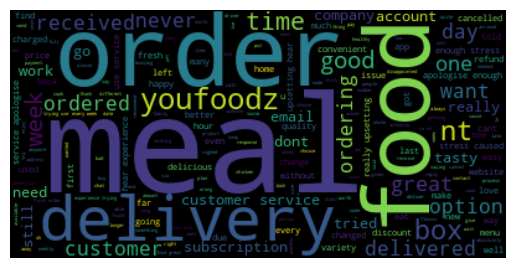

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert 'processed_text' column to strings
df['processed_text'] = df['processed_text'].astype(str)

# Generate a word cloud
wordcloud = WordCloud().generate(' '.join(df['processed_text']))

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


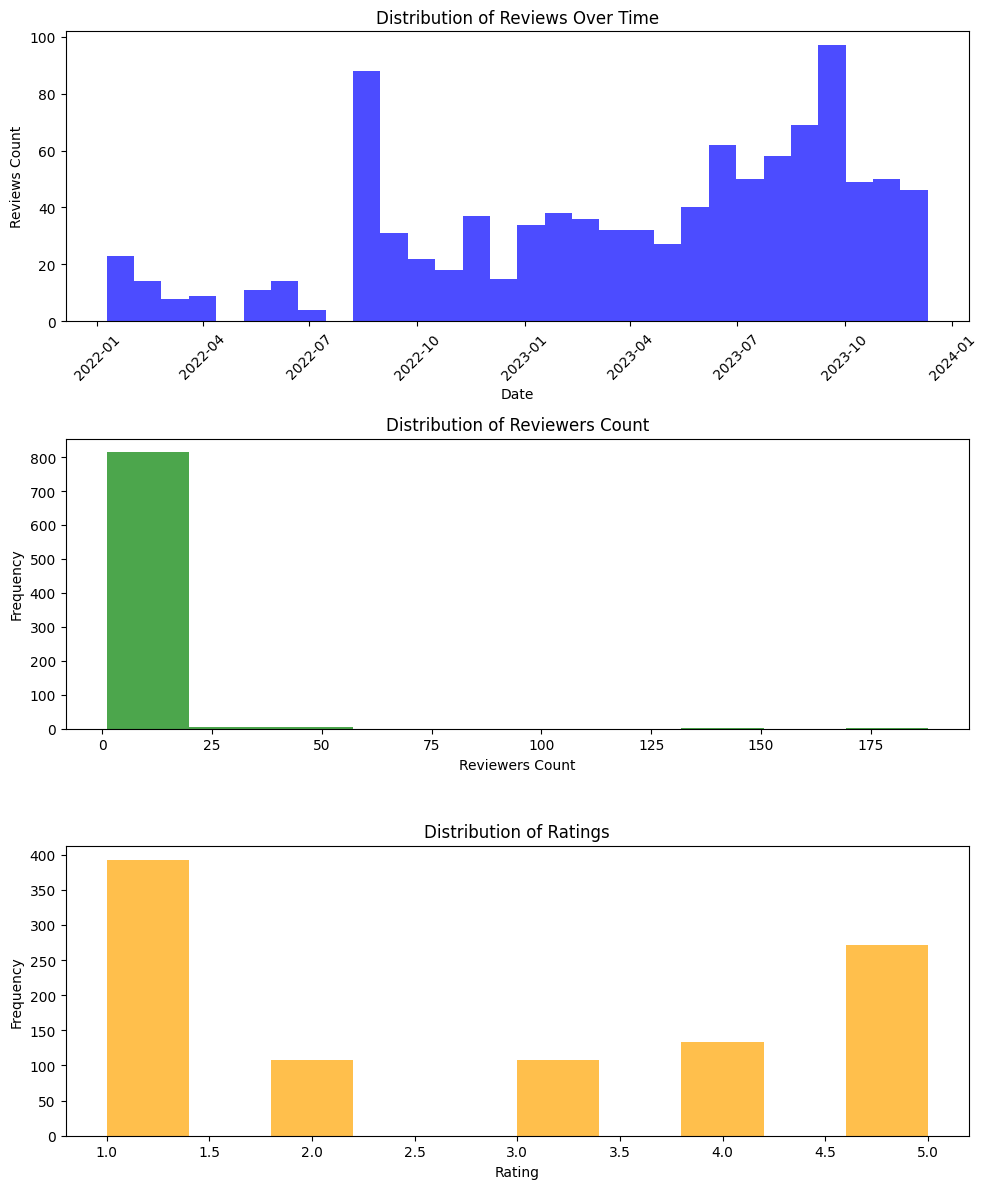

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# DataFrame named 'df'
df['Date of Experience'] = pd.to_datetime(df['Date of Experience'])

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Distribution of reviews over time
axs[0].hist(df['Date of Experience'], bins=30, color='blue', alpha=0.7)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Reviews Count')
axs[0].set_title('Distribution of Reviews Over Time')
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Distribution of reviewers count
axs[1].hist(df['Reviews Count'], color='green', alpha=0.7)
axs[1].set_xlabel('Reviewers Count')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Reviewers Count')

# Plot 3: Distribution of ratings
axs[2].hist(df['Rating'], color='orange', alpha=0.7)
axs[2].set_xlabel('Rating')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Ratings')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the combined plot
plt.show()


Top 10 Most Frequent Words:
[('meal', 892), ('order', 519), ('food', 416), ('delivery', 382), ('youfoodz', 290), ('nt', 281), ('box', 249), ('week', 244), ('service', 241), ('time', 211)]


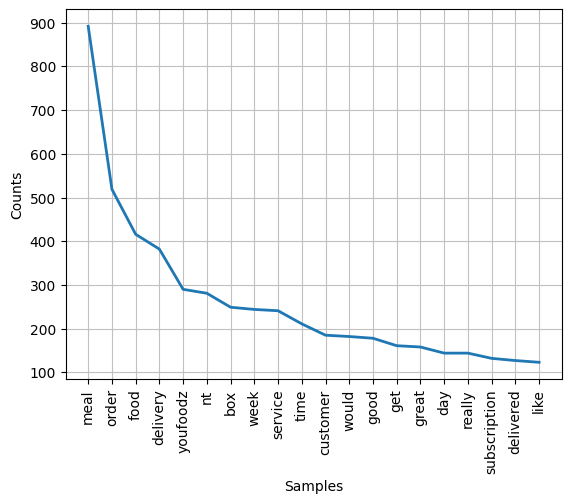

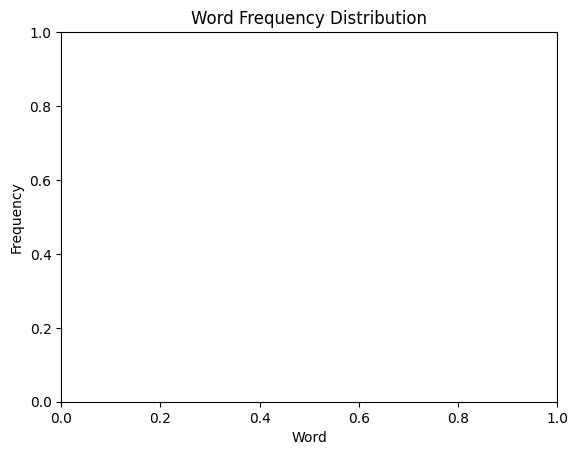

In [15]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Create a feature representing the length of each text
df['Text Length'] = df['processed_text'].apply(lambda x: len(word_tokenize(x)))

# Analyze the frequency of words in the corpus
corpus_text = ' '.join(df['processed_text'])
tokens = word_tokenize(corpus_text)
word_freq = FreqDist(tokens)

# Display the top 10 most frequent words
print("Top 10 Most Frequent Words:")
print(word_freq.most_common(10))

# Plot the word frequency distribution
word_freq.plot(20, cumulative=False)
plt.title('Word Frequency Distribution')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming your data is stored in a DataFrame named 'df'
# You may need to adjust the column indices based on the structure of your DataFrame

# Extracting features and labels
X = results_df['processed_text'].values  # Features (processed_text)
y = results_df['Sentiment'].values  # Labels (Sentiment)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Training the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = svm_model.predict(X_test_tfidf)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")





Accuracy: 90.15%


Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       122
           1       0.90      0.85      0.87        81

    accuracy                           0.90       203
   macro avg       0.90      0.89      0.90       203
weighted avg       0.90      0.90      0.90       203

Accuracy: 0.9014778325123153
F1 Score: 0.8734177215189873
Precision: 0.8961038961038961
Recall: 0.8518518518518519


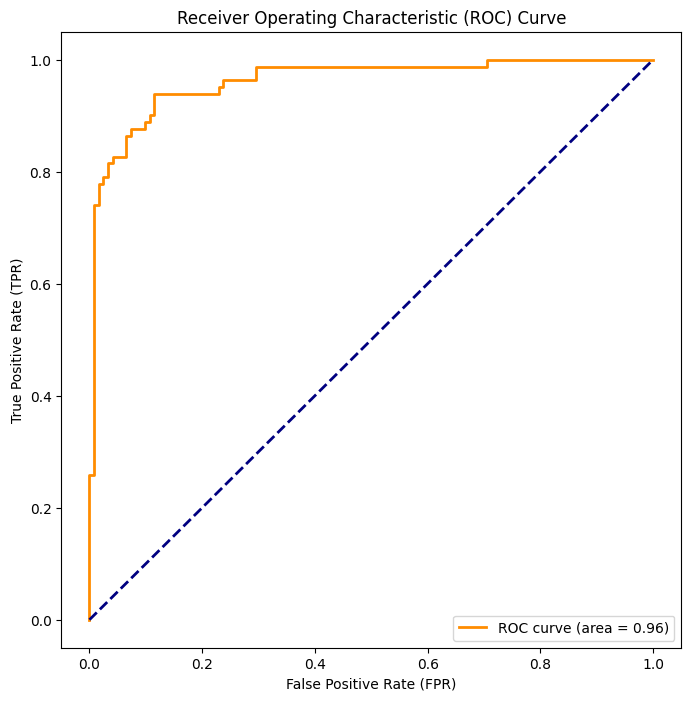

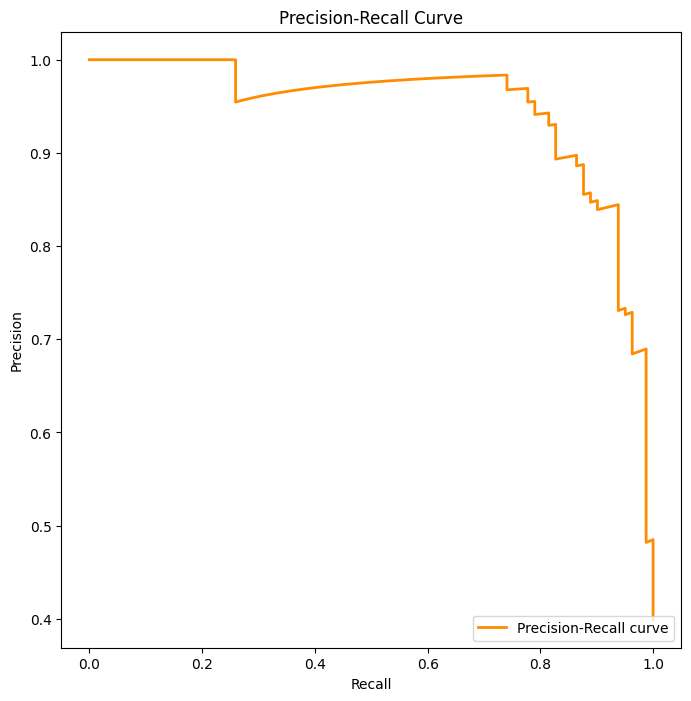

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Extracting features and labels
X = results_df['processed_text'].values  # Features (processed_text)
y = results_df['Sentiment'].values  # Labels (Sentiment)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SVM model
svm_model = SVC()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
}

# Perform Grid Search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Convert 'neg' and 'pos' labels to 0 and 1 for predicted labels
y_pred_binary = (y_pred == 'pos').astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

# Calculate and print accuracy
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print("Accuracy:", accuracy)

# Calculate and print F1 score, precision, and recall
f1 = f1_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, y_probs)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


In [59]:
# Convert 'neg' and 'pos' labels to 0 and 1
y_test_binary = (y_test == 'pos').astype(int)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_probs = best_model.decision_function(X_test_tfidf)  # Use decision_function or predict_proba based on your SVM model type

# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, y_probs)
roc_auc = auc(fpr, tpr)
print(f'ROC-AUC: {roc_auc:.4f}')

# Calculate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

ROC-AUC: 0.9620
Precision-Recall AUC: 0.9478
